In [33]:
%config StoreMagics.autorestore = True
%reset -f
# %store -z
%store -r
%whos

Variable           Type              Data/Info
----------------------------------------------
dvMathcalP         LinearIOSystem    <LinearIOSystem>: sys[87]<...>[[0. 0.]\n     [0. 0.]]\n
extMathcalP        LinearIOSystem    <LinearIOSystem>: sys[86]<...> [0. 0.]\n     [0. 0.]]\n
fullOrder          int               84
hsvDvMathcalP      ndarray           84: 84 elems, type `float64`, 672 bytes
hsvExtMathcalP     ndarray           84: 84 elems, type `float64`, 672 bytes
mathcalP_cb        LinearIOSystem    <LinearIOSystem>: sys[12]<...>[[0. 0.]\n     [0. 0.]]\n
reducOrder         int               5
truncDvMathcalP    LinearIOSystem    <LinearIOSystem>: sys[89]<...>[[0. 0.]\n     [0. 0.]]\n
truncExtMathcalP   LinearIOSystem    <LinearIOSystem>: sys[88]<...> [0. 0.]\n     [0. 0.]]\n


In [34]:
import numpy
import sympy
import scipy
import control
import matplotlib.pyplot as plt

from custom_utils import ControlUtils
from custom_utils import ODEUtils

from IPython.display import display
from IPython.display import Math
from IPython.display import Latex
from IPython.display import HTML

numpy.set_printoptions(precision=3)
sympy.init_printing(use_latex='mathjax', use_unicode=True)
sympy.init_printing()
plt.rcParams.update({ "text.usetex": True, "font.family": "Helvetica", "axes.titley": 1.0 })
%matplotlib inline

In [35]:
# Get plant
mathcalP = mathcalP_cb
# mathcalP = control.rss(100,2,2)
plantOrder = mathcalP.A.shape[0]
Ap = mathcalP.A
Bw = mathcalP.B[:,0:1]
Bu = mathcalP.B[:,1:2]
Cv = mathcalP.C[0:1,:]
Cy = mathcalP.C[1:2,:]

# Creating extended plant with [v,dv,y]^T as output
extMathcalP = control.ss(Ap,
                         numpy.column_stack([Bw, Bu]), 
                         numpy.row_stack([Cv, Cv@Ap, Cy]),
                         numpy.row_stack([
                             numpy.zeros( (Cv.shape[0],2) ),
                             numpy.column_stack([ Cv@Bw, Cv@Bu ]),
                             numpy.zeros( (Cy.shape[0],2) )
                         ])
                        )
normInfExtMathcalP = ControlUtils.hinfnorm(extMathcalP)
display(Math('\\lVert \\mathcal{P}_{ext} \\rVert_{\\infty} = ' + str(normInfExtMathcalP)))
# print(extMathcalP.C[:,0:5])

# # Creating extended plant with only u as input and [v,dv,y]^T as output
# extMathcalPu = control.ss(Ap,
#                          numpy.column_stack([Bu]), 
#                          numpy.row_stack([Cv, Cv@Ap, Cy]),
#                          numpy.row_stack([
#                              numpy.zeros( (Cv.shape[0],1) ),
#                              numpy.column_stack([ Cv@Bu ]),
#                              numpy.zeros( (Cy.shape[0],1) )
#                          ])
#                         )
# normInfExtMathcalPu = ControlUtils.hinfnorm(extMathcalPu)
# display(Math('\\lVert \\mathcal{P}_{u,ext} \\rVert_{\\infty} = ' + str(normInfExtMathcalP)))

# Creating plant with with [dv,y]^T as output
dvMathcalP = control.ss(Ap,
                         numpy.column_stack([Bw, Bu]), 
                         numpy.row_stack([Cv@Ap, Cy]),
                         numpy.row_stack([
                             numpy.column_stack([ Cv@Bw, Cv@Bu ]),
                             numpy.zeros( (Cy.shape[0],2) )
                         ])
                        )
normInfDvMathcalP = ControlUtils.hinfnorm(dvMathcalP)
display(Math('\\lVert \\mathcal{P}_{\\dot{v}} \\rVert_{\\infty} = ' + str(normInfDvMathcalP)))
# print(dvMathcalP.C[:,0:5])

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [36]:
# Defining reduction parameters
fullOrder = Ap.shape[0]
reducOrder = 10
display(Math("\\text{Full order} = " + str(fullOrder)))
display(Math("\\text{Reduced order} = " + str(reducOrder)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [37]:
# truncExtMathcalP = control.modelsimp.balred(extMathcalP, reducOrder, method='truncate')
truncExtMathcalP, hsvExtMathcalP, _ = ControlUtils.balaced_truncation(extMathcalP, reducOrder)
normInfTruncExtMathcalP = ControlUtils.hinfnorm(truncExtMathcalP)
display(Math('\\lVert \\widehat{\\mathcal{P}_{ext}} \\rVert_{\\infty} = ' + str(normInfTruncExtMathcalP)))

# truncExtMathcalPu, hsvExtMathcalPu, (T, proj, V_proj, WT_proj) = ControlUtils.balaced_truncation(extMathcalPu, reducOrder) # type: ignore
# normInfTruncExtMathcalPu = ControlUtils.hinfnorm(truncExtMathcalPu)
# display(Math('\\lVert \\widehat{\\mathcal{P}_{u,ext}} \\rVert_{\\infty} = ' + str(normInfTruncExtMathcalPu)))

# truncDvMathcalP = control.modelsimp.balred(dvMathcalP, reducOrder, method='truncate')
truncDvMathcalP, hsvDvMathcalP, _ = ControlUtils.balaced_truncation(dvMathcalP, reducOrder)
normInfTruncDvMathcalP = ControlUtils.hinfnorm(truncDvMathcalP)
display(Math('\\lVert \\widehat{\\mathcal{P}_{\\dot{v}}} \\rVert_{\\infty} = ' + str(normInfTruncDvMathcalP)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [38]:
# Re creating extended plant with [v,dv,y]^T as output and only u as input
# truncExtMathcalPu = control.ss(truncExtMathcalPu.A,
#                          numpy.column_stack([WT_proj@extMathcalP.B[:,0:1], truncExtMathcalPu.B]), 
#                          truncExtMathcalPu.C,
#                          numpy.column_stack([extMathcalP.D[:,0:1], truncExtMathcalPu.D])
#                         )
# normInfTruncExtMathcalPu = ControlUtils.hinfnorm(truncExtMathcalPu)
# display(Math('\\lVert \\mathcal{P}_{u,ext} \\rVert_{\\infty} = ' + str(normInfTruncExtMathcalPu)))

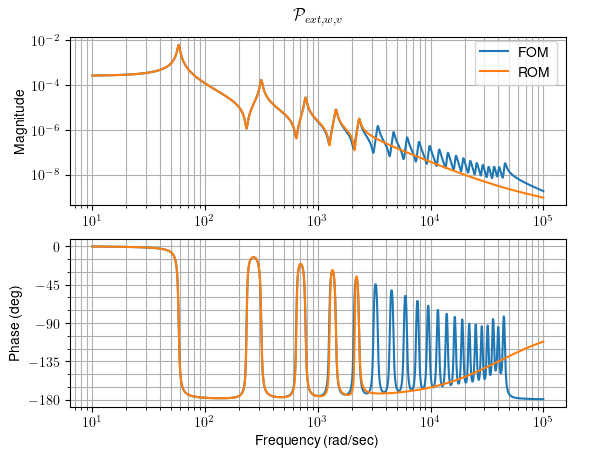

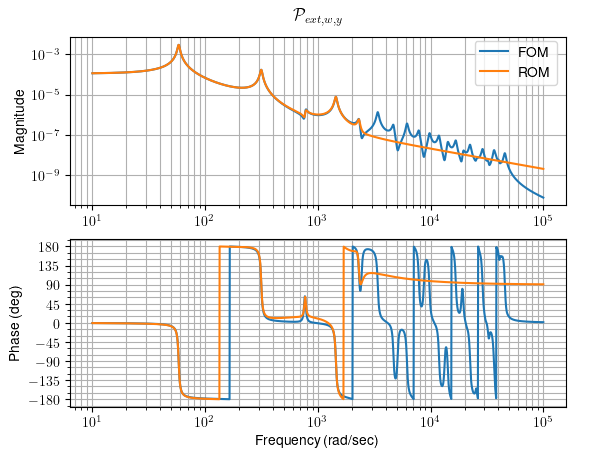

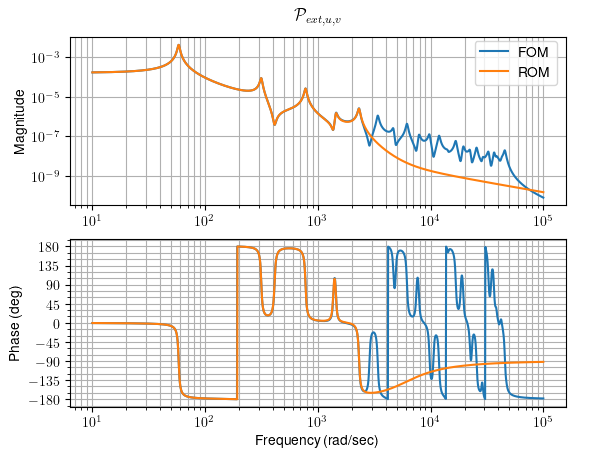

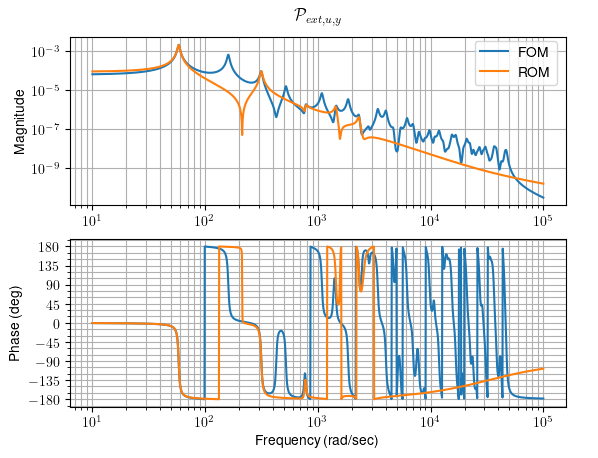

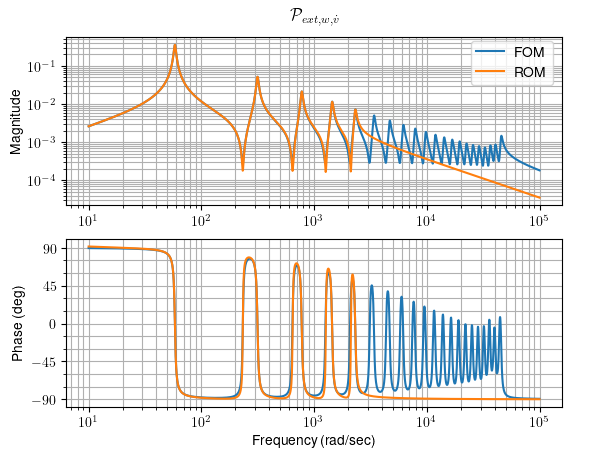

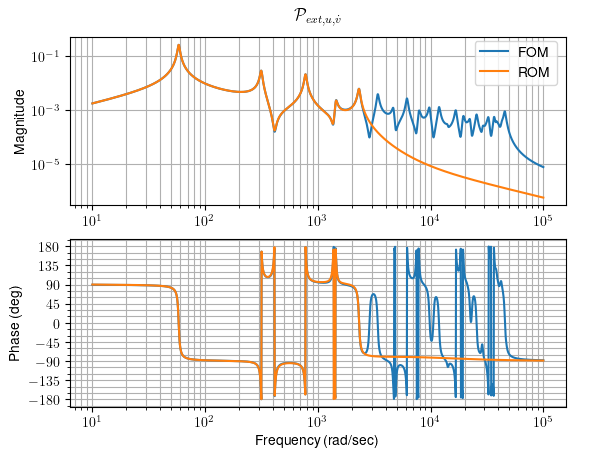

In [39]:
# Plotting FOM/ROM bodes for comparison
freq = numpy.logspace(1,5,2000) # rads/sec

control.bode_plot(extMathcalP[0,0], freq, label='FOM', wrap_phase=True, deg=True )
control.bode_plot(truncExtMathcalP[0,0], freq, label='ROM', wrap_phase=True, deg=True )
# control.bode_plot(truncExtMathcalPu[0,0], freq, label='ROMu', wrap_phase=True, deg=True )
plt.figlegend( ['FOM','ROM'], borderaxespad=3 )
plt.title( '$\\mathcal{P}_{ext,w,v}$', y=2.25 )
plt.show()

control.bode_plot(extMathcalP[2,0], freq, label='FOM', wrap_phase=True, deg=True )
control.bode_plot(truncExtMathcalP[2,0], freq, label='ROM', wrap_phase=True, deg=True )
# control.bode_plot(truncExtMathcalPu[2,0], freq, label='ROMu', wrap_phase=True, deg=True )
plt.figlegend( ['FOM','ROM'], borderaxespad=3 )
# control.bode_plot(dvMathcalP[1,0], freq, label='FOM $\\dot{v}$', wrap_phase=True, deg=True )
# control.bode_plot(truncDvMathcalP[1,0], freq, label='ROM $\\dot{v}$', wrap_phase=True, deg=True )
# plt.figlegend( ['FOM','ROM','FOM $\\dot{v}$','ROM $\\dot{v}$'], borderaxespad=3 )
plt.title( '$\\mathcal{P}_{ext,w,y}$', y=2.25 )
plt.show()

control.bode_plot(extMathcalP[0,1], freq, label='FOM', wrap_phase=True, deg=True )
control.bode_plot(truncExtMathcalP[0,1], freq, label='ROM', wrap_phase=True, deg=True )
# control.bode_plot(truncExtMathcalPu[0,1], freq, label='ROMu', wrap_phase=True, deg=True )
plt.figlegend( ['FOM','ROM'], borderaxespad=3 )
plt.title( '$\\mathcal{P}_{ext,u,v}$', y=2.25 )
plt.show()

control.bode_plot(extMathcalP[2,1], freq, label='FOM', wrap_phase=True, deg=True )
control.bode_plot(truncExtMathcalP[2,1], freq, label='ROM', wrap_phase=True, deg=True )
# control.bode_plot(truncExtMathcalPu[2,1], freq, label='ROMu', wrap_phase=True, deg=True )
plt.figlegend( ['FOM','ROM'], borderaxespad=3 )
# control.bode_plot(dvMathcalP[1,1], freq, label='FOM $\\dot{v}$', wrap_phase=True, deg=True )
# control.bode_plot(truncDvMathcalP[1,1], freq, label='ROM $\\dot{v}$', wrap_phase=True, deg=True )
# plt.figlegend( ['FOM','ROM','FOM $\\dot{v}$','ROM $\\dot{v}$'], borderaxespad=3 )
plt.title( '$\\mathcal{P}_{ext,u,y}$', y=2.25 )
plt.show()

control.bode_plot(extMathcalP[1,0], freq, label='FOM', wrap_phase=True, deg=True )
control.bode_plot(truncExtMathcalP[1,0], freq, label='ROM', wrap_phase=True, deg=True )
# control.bode_plot(truncExtMathcalPu[1,0], freq, label='ROMu', wrap_phase=True, deg=True )
plt.figlegend( ['FOM','ROM'], borderaxespad=3 )
# control.bode_plot(dvMathcalP[0,0], freq, label='FOM $\\dot{v}$', wrap_phase=True, deg=True )
# control.bode_plot(truncDvMathcalP[0,0], freq, label='ROM $\\dot{v}$', wrap_phase=True, deg=True )
# plt.figlegend( ['FOM','ROM','FOM $\\dot{v}$','ROM $\\dot{v}$'], borderaxespad=3 )
plt.title( '$\\mathcal{P}_{ext,w,\\dot{v}}$', y=2.25 )
plt.show()

control.bode_plot(extMathcalP[1,1], freq, label='FOM', wrap_phase=True, deg=True )
control.bode_plot(truncExtMathcalP[1,1], freq, label='ROM', wrap_phase=True, deg=True )
# control.bode_plot(truncExtMathcalPu[1,1], freq, label='ROMu', wrap_phase=True, deg=True )
plt.figlegend( ['FOM','ROM'], borderaxespad=3 )
# control.bode_plot(dvMathcalP[0,1], freq, label='FOM $\\dot{v}$', wrap_phase=True, deg=True )
# control.bode_plot(truncDvMathcalP[0,1], freq, label='ROM $\\dot{v}$', wrap_phase=True, deg=True )
# plt.figlegend( ['FOM','ROM','FOM $\\dot{v}$','ROM $\\dot{v}$'], borderaxespad=3 )
plt.title( '$\\mathcal{P}_{ext,u,\\dot{v}}$', y=2.25 )
plt.show()

In [40]:
%store -d extMathcalP truncExtMathcalP hsvExtMathcalP dvMathcalP truncDvMathcalP hsvDvMathcalP fullOrder reducOrder
%store extMathcalP truncExtMathcalP hsvExtMathcalP dvMathcalP truncDvMathcalP hsvDvMathcalP fullOrder reducOrder

Stored 'extMathcalP' (LinearIOSystem)
Stored 'truncExtMathcalP' (LinearIOSystem)
Stored 'hsvExtMathcalP' (ndarray)
Stored 'dvMathcalP' (LinearIOSystem)
Stored 'truncDvMathcalP' (LinearIOSystem)
Stored 'hsvDvMathcalP' (ndarray)
Stored 'fullOrder' (int)
Stored 'reducOrder' (int)
